# Lab 4: Ensemble Models


In this lab we'll get some hands on experience with ensemble classifiers we've seen in class


## Goals for this lab

- Understand the practical implications for changing the parameters used in ensemble models such as bagging, boosting, and random forests.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import roc_curve, auc
import graphviz # If you don't have this, install via pip/conda
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# exercise: what additional modules should you import?

# Data
We'll continue to use the same data as in the previous lab.

It is a subset of the data set from https://www.kaggle.com/new-york-state/nys-patient-characteristics-survey-pcs-2015

The data has been downloaded, modified, and is in the github repo for the lab

You should also try this with other data sets you have been provided for the homeworks.

In [2]:
# Change this to wherever you're storing your data
datafile = '../data/nysmedicaldata.csv'
df = pd.read_csv(datafile)

In [3]:
df.head()

,Region Served,Age Group,Sex,Transgender,Sexual Orientation,Hispanic Ethnicity,Race,Living Situation,Household Composition,Preferred Language,...,No Insurance,Unknown Insurance Coverage,Medicaid Insurance,Medicaid Managed Insurance,Medicare Insurance,Private Insurance,Child Health Plus Insurance,Other Insurance,Criminal Justice Status,Three Digit Residence Zip Code
0,HUDSON RIVER REGION,ADULT,MALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,YES,OTHER,OTHER LIVING SITUATION,NOT APPLICABLE,ENGLISH,...,NO,NO,YES,NO,NO,NO,NO,NO,YES,113
1,NEW YORK CITY REGION,ADULT,MALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,INSTITUTIONAL SETTING,NOT APPLICABLE,ENGLISH,...,NO,NO,YES,NO,UNKNOWN,NO,NO,UNKNOWN,YES,113
2,HUDSON RIVER REGION,ADULT,MALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,PRIVATE RESIDENCE,COHABITATES WITH OTHERS,ENGLISH,...,NO,NO,YES,NO,NO,NO,NO,NO,YES,107
3,NEW YORK CITY REGION,ADULT,FEMALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",OTHER,OTHER LIVING SITUATION,NOT APPLICABLE,ASIAN AND PACIFIC ISLAND,...,YES,NO,NO,NOT APPLICABLE,NO,NO,NO,NO,YES,888
4,LONG ISLAND REGION,ADULT,MALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",BLACK ONLY,OTHER LIVING SITUATION,NOT APPLICABLE,ENGLISH,...,NO,NO,YES,UNKNOWN,YES,NO,NO,NO,NO,117


## 1. Create label/outcome
One thing we can do with this dataset is to try to use the various feature columns to classify whether a person has High Blood Pressure. Let's create a column that is 1 if a person has High Blood Pressure and 0 otherwise

In [4]:
# code
df['HBP'] = np.where(df['High Blood Pressure']=="YES", 1, 0)

### Question: what percentage of people have High Blood Pressure?

In [5]:
# code
df['HBP'].mean()

0.21600738092492217

## 2. create or select existing predictors/features

For now, let's take a handful of existing columns to use.

sklearn needs features to be numeric and not categorical so we'll have to turn our selected features to be binary (also known as dummy variables)

In [6]:
# code
cols_to_transform = [ 'Sex', 'Race', 'Obesity', 'Smokes', 'Alcohol Related Disorder','Drug Substance Disorder',
                    'Criminal Justice Status','Private Insurance']
df = pd.get_dummies( df, dummy_na=True, columns = cols_to_transform )
df.head()

,Region Served,Age Group,Transgender,Sexual Orientation,Hispanic Ethnicity,Living Situation,Household Composition,Preferred Language,Veteran Status,Employment Status,...,Drug Substance Disorder_YES,Drug Substance Disorder_nan,Criminal Justice Status_NO,Criminal Justice Status_UNKNOWN,Criminal Justice Status_YES,Criminal Justice Status_nan,Private Insurance_NO,Private Insurance_UNKNOWN,Private Insurance_YES,Private Insurance_nan
0,HUDSON RIVER REGION,ADULT,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,YES,OTHER LIVING SITUATION,NOT APPLICABLE,ENGLISH,NO,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,...,1,0,0,0,1,0,1,0,0,0
1,NEW YORK CITY REGION,ADULT,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",INSTITUTIONAL SETTING,NOT APPLICABLE,ENGLISH,NO,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,...,1,0,0,0,1,0,1,0,0,0
2,HUDSON RIVER REGION,ADULT,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",PRIVATE RESIDENCE,COHABITATES WITH OTHERS,ENGLISH,NO,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,...,0,0,0,0,1,0,1,0,0,0
3,NEW YORK CITY REGION,ADULT,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",OTHER LIVING SITUATION,NOT APPLICABLE,ASIAN AND PACIFIC ISLAND,NO,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,...,0,0,0,0,1,0,1,0,0,0
4,LONG ISLAND REGION,ADULT,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",OTHER LIVING SITUATION,NOT APPLICABLE,ENGLISH,NO,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,...,0,0,1,0,0,0,1,0,0,0


In [7]:
# code
selected_features = ['Sex_FEMALE','Sex_MALE','Sex_UNKNOWN','Race_BLACK ONLY','Race_MULTI-RACIAL','Race_OTHER',
                     'Race_UNKNOWN RACE','Race_WHITE ONLY', 'Obesity_YES', 'Obesity_NO', 'Obesity_nan', 
                     'Smokes_YES', 'Smokes_NO','Alcohol Related Disorder_NO','Alcohol Related Disorder_YES',
                    'Alcohol Related Disorder_UNKNOWN','Criminal Justice Status_YES','Criminal Justice Status_NO',
                    'Criminal Justice Status_UNKNOWN','Private Insurance_NO','Private Insurance_YES','Private Insurance_UNKNOWN']

# Train/Test Splits

Create a train/test set split using sklearn's [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. We'll use these train/test splits for evaluating all our classification models.

In [8]:
# code
x = df[selected_features]
y = df['HBP']
test_size = 0.3 # you can adjust this
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

# Bagging
See the sklearn documentation on sklearn.ensemble.BaggingClassifier to see its parameters. We'll mostly be interested in:
- n_estimators
You can explore 2 more:
- base_estimator
- n_jobs

Remember that when training a model, **you should only use the training data!** The test set is reserved exclusively for evaluating your model. Now let's use the classifier:

In [9]:
# code
bagging = BaggingClassifier(n_jobs=-1) # use the default parameters: base_estimator is a decision tree, n_estimators=10
bagging.fit(x_train, y_train)
pred_scores = bagging.predict_proba(x_test)

## Bagging Tasks:

The goal here is to explore different parameters to see their impact. How does each performance metric change, using different thresholds, as you vary the parameters?  You can write a nested for loop that loops over all the parameters and values.

In [12]:
# CODE
print("The true number of HBP is {}/{} from the testing data, with percentage {:.2f}%\n".format(
    sum(y_test), len(y_test), 100.*sum(y_test)/len(y_test)))

for threshold in tqdm(np.linspace(0.1,0.9,9)):
    pred_label = [1 if x[1]>threshold else 0 for x in pred_scores]
    print("Threshold: {} | total predicted HBP is {} | accuracy is {:.2f} | f1_score is {:.2f}".format(
        threshold, sum(pred_label), accuracy(pred_label,y_test), f1_score(y_test, pred_label)))


The true number of HBP is 557/2602 from the testing data, with percentage 21.41%



  0%|                                                                      | 0/9 [00:00<?, ?it/s]

Threshold: 0.1 | total predicted HBP is 2349 | accuracy is 0.28 | f1_score is 0.36
Threshold: 0.2 | total predicted HBP is 1432 | accuracy is 0.50 | f1_score is 0.35
Threshold: 0.30000000000000004 | total predicted HBP is 354 | accuracy is 0.74 | f1_score is 0.25
Threshold: 0.4 | total predicted HBP is 159 | accuracy is 0.76 | f1_score is 0.15
Threshold: 0.5 | total predicted HBP is 68 | accuracy is 0.77 | f1_score is 0.06
Threshold: 0.6 | total predicted HBP is 20 | accuracy is 0.78 | f1_score is 0.01
Threshold: 0.7000000000000001 | total predicted HBP is 11 | accuracy is 0.78 | f1_score is 0.00
Threshold: 0.8 | total predicted HBP is 8 | accuracy is 0.78 | f1_score is 0.00
Threshold: 0.9 | total predicted HBP is 1 | accuracy is 0.79 | f1_score is 0.00


100%|█████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 173.54it/s]


If we take both Accuracy and F1 score into consideration, threshold=0.3 is a good choice.

## What is the effect of changing the base_estimator?

What happens when you use different models inside bagging? What if you use logistic regresssion? Does the performance of LR by itself better or worse than if you use it with bagging? How does it change if you increase the number of estimators (bags)? 

You can try it with a simple metric at first, let's say AUC.

In [19]:
def draw_roc_curve(fpr, tpr):

    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


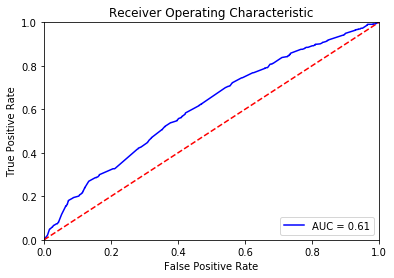

The AUC under the original default setting of bagging is 0.612


In [20]:
# CODE
fpr, tpr, thresholds = roc_curve(y_test, pred_scores[:,1], pos_label=1)
draw_roc_curve(fpr, tpr)
print("The AUC under the original default setting of bagging is {:.3f}".format(auc(fpr, tpr)))

Now let's use logistic regression as base estimator.

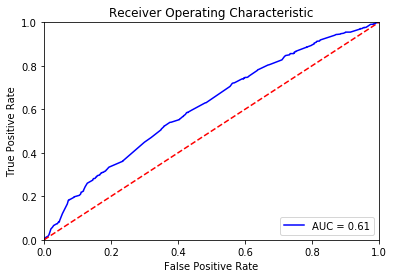

The AUC of bagging with Logistic Regression as base_estimator is 0.613


In [21]:
# CODE
bagging = BaggingClassifier(base_estimator=LogisticRegression(solver='liblinear'),
                            n_jobs=-1)
bagging.fit(x_train, y_train)
pred_scores = bagging.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, pred_scores[:,1], pos_label=1)

draw_roc_curve(fpr, tpr)

print("The AUC of bagging with Logistic Regression as base_estimator is {:.3f}".format(auc(fpr, tpr)))

It seems that Logistic Regression is a better candidate than decision tree as base_estimator. Let's see how does LR itself perform without bagging.

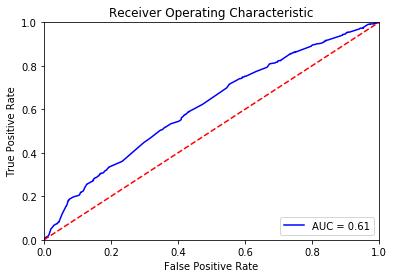

The AUC of logistic regression itself is 0.613


In [23]:
# CODE
classifier = LogisticRegression(solver='liblinear')
classifier.fit(x_train, y_train)
pred_scores = classifier.predict_proba(x_test)
fpr, tpr, thresholds = roc_curve(y_test, pred_scores[:,1], pos_label=1)

draw_roc_curve(fpr, tpr)
print("The AUC of logistic regression itself is {:.3f}".format(auc(fpr, tpr)))

Seems logistic regression without bagging is performing good. Can bagging outperform it with increasing number of bags?

  0%|                                                                      | 0/4 [00:00<?, ?it/s]

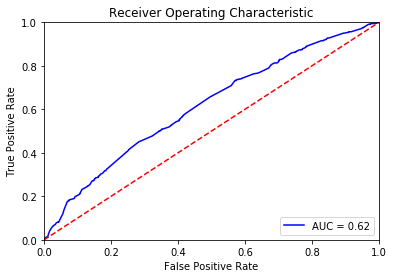

The AUC of Bagging with Logistic Regression & 10 n_estimators is 0.616


 25%|███████████████▌                                              | 1/4 [00:02<00:07,  2.52s/it]

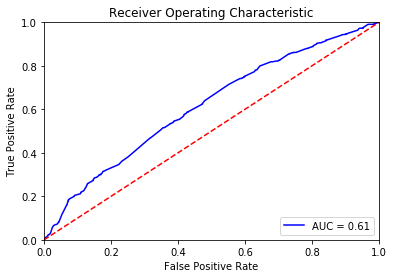

The AUC of Bagging with Logistic Regression & 25 n_estimators is 0.614


 50%|███████████████████████████████                               | 2/4 [00:02<00:03,  1.83s/it]

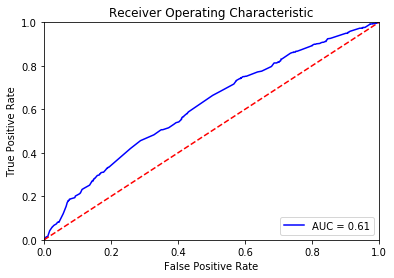

The AUC of Bagging with Logistic Regression & 50 n_estimators is 0.615


 75%|██████████████████████████████████████████████▌               | 3/4 [00:03<00:01,  1.38s/it]

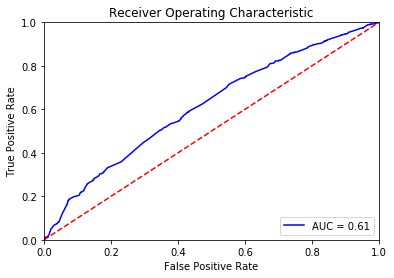

The AUC of Bagging with Logistic Regression & 100 n_estimators is 0.613


100%|██████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.10s/it]


In [25]:
# CODE
for n_estimator in tqdm([10, 25, 50, 100]):
    bagging = BaggingClassifier(base_estimator=LogisticRegression(solver='liblinear'),
                                n_estimators=n_estimator,
                                n_jobs=-1)
    bagging.fit(x_train, y_train)
    pred_scores = bagging.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, pred_scores[:,1], pos_label=1)

    draw_roc_curve(fpr, tpr)

    print("The AUC of Bagging with Logistic Regression & {} n_estimators is {:.3f}".format(n_estimator, auc(fpr, tpr)))

# Boosting
We'll start by using adaboost, that is one of the boosting classifiers implemented in sklearn.
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

Similar to bagging, there are two parameters to explore:
- n_estimators (number of rounds of boosting)
- base_estimator

Why is there no n_jobs parameter here?



We can explore other boosting methods later such as gradient boosting
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

In [26]:
boost = AdaBoostClassifier() # use the default parameters: base_estimator is a decision tree, n_estimators=50
boost.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

### Now predict scores on the test set and plot the distribution of scores

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.601e+03]),
 array([0.31740843, 0.33557891, 0.35374938, 0.37191986, 0.39009033,
        0.40826081, 0.42643128, 0.44460175, 0.46277223, 0.4809427 ,
        0.49911318]),
 <a list of 10 Patch objects>)

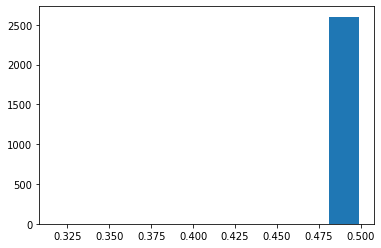

In [27]:
pred_scores = boost.predict_proba(x_test)
plt.hist(pred_scores[:,1])

### now we can select a threshold and calculate accuracy

In [28]:
# CODE
print("The true number of HBP is {}/{} from the testing data, with percentage {:.2f}%\n".format(
    sum(y_test), len(y_test), 100.*sum(y_test)/len(y_test)))

for threshold in np.linspace(0.488,0.498,10):
    pred_label = [1 if x[1]>threshold else 0 for x in pred_scores]
    print("(Threshold: {:.3f}), the total number of predicted HBP is {}, the accuracy is {:.2f}, the f1_score is {:.2f}".format(
        threshold, sum(pred_label), accuracy(pred_label,y_test), f1_score(y_test, pred_label)))
    print

The true number of HBP is 557/2602 from the testing data, with percentage 21.41%

(Threshold: 0.488), the total number of predicted HBP is 2599, the accuracy is 0.21, the f1_score is 0.35
(Threshold: 0.489), the total number of predicted HBP is 2558, the accuracy is 0.23, the f1_score is 0.35
(Threshold: 0.490), the total number of predicted HBP is 2472, the accuracy is 0.25, the f1_score is 0.36
(Threshold: 0.491), the total number of predicted HBP is 2129, the accuracy is 0.35, the f1_score is 0.37
(Threshold: 0.492), the total number of predicted HBP is 1646, the accuracy is 0.48, the f1_score is 0.38
(Threshold: 0.494), the total number of predicted HBP is 1147, the accuracy is 0.58, the f1_score is 0.37
(Threshold: 0.495), the total number of predicted HBP is 487, the accuracy is 0.72, the f1_score is 0.31
(Threshold: 0.496), the total number of predicted HBP is 340, the accuracy is 0.75, the f1_score is 0.27
(Threshold: 0.497), the total number of predicted HBP is 132, the accura

### Let's now vary values of n_estimators and see the results.

In [29]:
# CODE
for n_estimators in [1,5,10,50, 100, 200, 500, 1000]:
    boost = AdaBoostClassifier(n_estimators=n_estimators) # use the default parameters: base_estimator is a decision tree, n_estimators=50
    boost.fit(x_train, y_train)
    pred_scores = boost.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, pred_scores[:,1], pos_label=1)
    
    print("(n_estimators: {}), the AUC of logistic regression it self is {:.5f}".format(n_estimators, auc(fpr, tpr)))

(n_estimators: 1), the AUC of logistic regression it self is 0.56033
(n_estimators: 5), the AUC of logistic regression it self is 0.60524
(n_estimators: 10), the AUC of logistic regression it self is 0.60758
(n_estimators: 50), the AUC of logistic regression it self is 0.61375
(n_estimators: 100), the AUC of logistic regression it self is 0.61334
(n_estimators: 200), the AUC of logistic regression it self is 0.61337
(n_estimators: 500), the AUC of logistic regression it self is 0.61337
(n_estimators: 1000), the AUC of logistic regression it self is 0.61337


### what happens if we use a different base_estimator?

In [ ]:
# CODE


### Now let's build precision, recall, % of population graphs for all the models above varying the different parameters 

In [30]:
# CODE
bagging = BaggingClassifier() # use the default parameters: base_estimator is a decision tree, n_estimators=10
bagging.fit(x_train, y_train)
pred_scores = bagging.predict_proba(x_test)
precision, recall, thresholds = precision_recall_curve(y_test, pred_scores[:,1],pos_label=1)
population = [1.*sum(pred_scores[:,1]>threshold)/len(pred_scores) for threshold in thresholds]

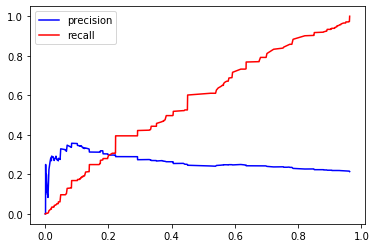

In [31]:
p, = plt.plot(population, precision[:-1], color='b') # last element of precision is 0
r, = plt.plot(population, recall[:-1], color='r') # last element of recall is 1
plt.legend([p, r], ['precision', 'recall'])
plt.show()

In [33]:
boost = AdaBoostClassifier(base_estimator=LogisticRegression(solver='liblinear'))
boost.fit(x_train, y_train)
pred_scores = boost.predict_proba(x_test)
precision, recall, thresholds = precision_recall_curve(y_test, pred_scores[:,1],pos_label=1)
population = [1.*sum(pred_scores[:,1]>threshold)/len(pred_scores) for threshold in thresholds]

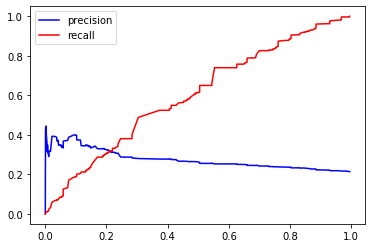

In [34]:
p, = plt.plot(population, precision[:-1], color='b') # last element of precision is 1
r, = plt.plot(population, recall[:-1], color='r') # last element of recall is 0
plt.legend([p, r], ['precision', 'recall'])
plt.show()

In [36]:
classifier = LogisticRegression(solver='liblinear')
classifier.fit(x_train, y_train)
pred_scores = classifier.predict_proba(x_test)
precision, recall, thresholds = precision_recall_curve(y_test, pred_scores[:,1],pos_label=1)
population = [1.*sum(pred_scores[:,1]>threshold)/len(pred_scores) for threshold in thresholds]

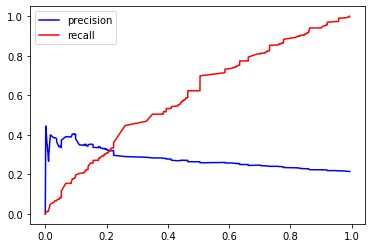

In [37]:
p, = plt.plot(population, precision[:-1], color='b') # last element of precision is 1
r, = plt.plot(population, recall[:-1], color='r') # last element of recall is 0
plt.legend([p, r], ['precision', 'recall'])
plt.show()

### what can we learn about bagging and boosting from these results?

### do bagging and boosting always improve over the base estimator used?

# Random Forests
If you have time, you can get started on exploring Random Forests that we'll cover in the next class.
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

